### Resources

https://huggingface.co/docs/datasets/use_with_pytorch
https://huggingface.co/docs/datasets/v2.14.5/en/image_load

**Process images:**
- image processing: https://huggingface.co/docs/datasets/image_process#map
- transforms methods: https://pytorch.org/vision/stable/transforms.html#transforms
- HF general processing: https://huggingface.co/docs/datasets/process
- transforms v2 reference: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

**Test/Train split**
- use this: https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/main_classes#datasets.Dataset.train_test_split

**Follow rest of tutorial**
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

**Building a Model Basics**
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [2]:
# import libraries
import numpy as np
import pandas as pd
import datasets 
from datasets import Features, Image, load_dataset, load_dataset_builder, config, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os

# import shutil
# import pathlib
# import PIL
# from PIL import Image

import torch
import torchvision
from torchvision.transforms import v2, ToTensor, Lambda
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

In [3]:
# check for GPU and create the device object
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [4]:
# get data (from https://huggingface.co/datasets/YakupAkdin/instrument-images/tree/main)
dataset = load_dataset("YakupAkdin/instrument-images", split='train').with_format("torch", device=device)

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
label_values = {
    0: 'harp',
    1: 'baglama',
    2: 'electric guitar',
    3: 'acoustic guitar',
    4: 'kanun',
    5: 'violin',
    6: 'kemence',
    7: 'mandolin',
    8: 'oud',
    9: 'yayli tambur'}

inverted_labels = {v: k for k, v in label_values.items()}

In [6]:
dataset_RGB = dataset.filter(lambda x: x['image'].dim() == 3)
len(dataset_RGB)

989

In [7]:
# the RGB images are [H,W,3] and PyTorch needs them as [3,H,W]
# included [:3, :, :] slice to adjust any RGBA images to RGB
print(dataset_RGB[0]['image'].shape)

# permute the tensors
def permute_images(batch):
    # Apply the permute operation to each tensor in the batch
    batch['image'] = [img.permute(2, 0, 1)[:3, :, :] for img in batch['image']]
    return batch

dataset_RGB = dataset_RGB.map(permute_images, batched=True, batch_size=10)

dataset_RGB[0]['image'].shape

torch.Size([720, 1280, 3])


torch.Size([3, 720, 1280])

In [8]:
dataset_greyscale = dataset.filter(lambda x: x['image'].dim() == 2)
len(dataset_greyscale)

11

In [9]:
# some of the images are greyscale, so we convert to RGB as well
print(dataset_greyscale[0]['image'].shape)

def grayscale_to_rgb(item):
    item['image'] = item['image'].unsqueeze(0).repeat(3, 1, 1)
    return item

dataset_greyscale = dataset_greyscale.map(grayscale_to_rgb)
print(dataset_greyscale[0]['image'].shape)

torch.Size([849, 900])
torch.Size([3, 849, 900])


In [10]:
# concatenate both reformatted RGB datasets
dataset = concatenate_datasets([dataset_RGB, dataset_greyscale])

In [11]:
# confirming 0-255 scaling of image tensors
sample_image = dataset[0]['image']

print("Sample values:", sample_image.flatten()[:10])
print("Max value:", sample_image.max().item())
print("Min value:", sample_image.min().item())

Sample values: tensor([40, 39, 41, 41, 41, 44, 48, 53, 54, 52], device='cuda:0')
Max value: 255
Min value: 0


In [12]:
# rescale tensors from 0-255 to 0-1
class ScaleTensor(object):
    def __call__(self, tensor):
        return tensor / 255.

basic_transform = v2.Compose([
    ScaleTensor(),
    v2.Resize(32),
    v2.CenterCrop(32),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# application function for transforms
def apply_transform(example):
    # Apply the transformation to the 'image' field
    example['image'] = [basic_transform(img) for img in example['image']]
    return example

# apply transforms
dataset = dataset.map(apply_transform, batched=True, batch_size=10)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### Examine Dataset/Model Compatibility Before Training

In [14]:
# check: are tensor values normalized to [-1, 1]?

correct_tensor_range = 0

for i, image in enumerate(dataset['image']):
    if image.min() < -1 or image.max() > 1:
        print(f"Image at index {i} has values outside expected range: min={image.min()}, max={image.max()}")
    else:
        correct_tensor_range += 1

print(correct_tensor_range)

1000


In [15]:
# check: are all tensors shape [3, 32, 32]?

correct_tensor_shape = 0

for i in range(len(dataset)):
    if dataset[i]['image'].shape != torch.Size([3, 32, 32]):
        print(f"Image at index {i} has incorrect shape: {image.shape}")
    else:
        correct_tensor_shape += 1

print(correct_tensor_shape)

1000


In [18]:
# checking images and labels for consistency
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
def check_instrument(instr, ds):

    check = ds.filter(lambda x: x['label'] == instr)
    images = check['image'][0:32]
    labels = check['label'][0:32]

    # show images & labels
    imshow(torchvision.utils.make_grid(images.cpu()))

    label_list = ''
    for i, lbl in enumerate(labels):
        label_list += label_values[labels[i].item()]
        if i % 8 == 7:
            label_list += '\n'
        else:
            label_list += ' | '
    print(label_list)

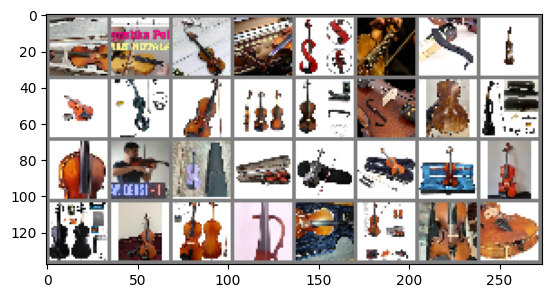

violin | violin | violin | violin | violin | violin | violin | violin
violin | violin | violin | violin | violin | violin | violin | violin
violin | violin | violin | violin | violin | violin | violin | violin
violin | violin | violin | violin | violin | violin | violin | violin



In [19]:
# should be all violins
check_instrument(5, dataset)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

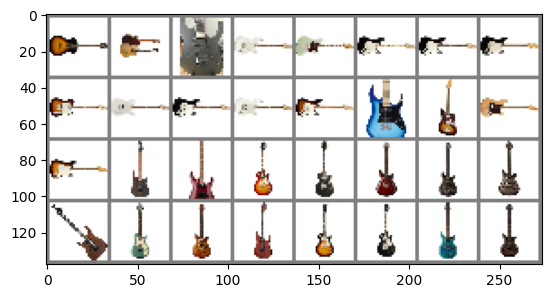

electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar
electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar
electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar
electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar | electric guitar



In [20]:
# should be all electric guitars
check_instrument(2, dataset)

### Dataloader Setup

In [21]:
# split test/train
dataset = dataset.train_test_split(test_size=0.2, seed=1, stratify_by_column="label")

In [22]:
batch_size = 4

trainloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, num_workers=0)

In [23]:
# check batch sizing (should be no output)
for batch in trainloader:
    if batch['image'].shape[0] != batch_size:
        print(f"Batch {i} has incorrect batch size: {images.shape[0]}")
    if batch['label'].shape[0] != batch_size:
        print(f"Batch {i} has mismatched images and labels")

In [24]:
# start with basic model from the tutorial

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
# Define loss function: Classification Cross-Entropy loss and SGD with momentum.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [33]:
training_log = {'epoch': [], 'loss' : [], 'train_acc': [], 'test_acc': [], 'model_state': []}

def train_model(modelname, start_epoch, end_epoch, model, trainloader, testloader, optimizer, criterion, training_log):

    for epoch in range(start_epoch, end_epoch): 
    
        # set baseline for epoch
        running_loss = 0.0
        train_labels, train_pred = [], []
        model.train()

        # loop through each batch of the training dataloader
        for i, data in enumerate(trainloader, 0):
            inputs = data['image']
            labels = data['label']
        
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # catalog training results
            _, predicted = torch.max(outputs, 1)
            train_labels.append(labels.cpu())
            train_pred.append(predicted.cpu())
        
            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                training_log['loss'].append(running_loss/200) # log the epoch loss before resetting it
                running_loss = 0.0

        # training results lists into tensors and calculate training accuracy
        train_labels = torch.cat(train_labels)
        train_pred = torch.cat(train_pred)
        train_acc = (train_pred == train_labels).sum().item() / train_labels.size(0)

        # test model after each training epoch
        test_labels, test_pred = [], []
        model.eval()
    
        for i, data in enumerate(testloader, 0):
            inputs = data['image']
            labels = data['label']
            outputs = model(inputs)

            # catalog test results
            _, predicted = torch.max(outputs, 1)
            test_labels.append(labels.cpu())
            test_pred.append(predicted.cpu())

        # test results lists into tensors and calculate test accuracy
        test_labels = torch.cat(test_labels)
        test_pred = torch.cat(test_pred)    
        test_acc = (test_pred == test_labels).sum().item() / test_labels.size(0)
    
        # add epoch details to training log
        training_log['epoch'].append(epoch) # epoch number
        training_log['train_acc'].append(train_acc) # training accuracy
        training_log['test_acc'].append(test_acc) # test accuracy

        # save the model
        cwd = os.getcwd()
        filename = f'{modelname}_state_epoch_{epoch}.pth'
        path = os.path.join(cwd, filename)
        torch.save(model.state_dict(), path)
        training_log['model_state'].append(path)
        print(f'epoch {epoch}: training complete')

In [31]:
train_model('mini', 0, 1, net, trainloader, testloader, optimizer, criterion, training_log)

In [34]:
# view the training results as a dataframe
train_model('mini', 1, 26, net, trainloader, testloader, optimizer, criterion, training_log)
training_results = pd.DataFrame.from_dict(training_log)

epoch 1 training complete
epoch 2 training complete
epoch 3 training complete
epoch 4 training complete
epoch 5 training complete
epoch 6 training complete
epoch 7 training complete
epoch 8 training complete
epoch 9 training complete
epoch 10 training complete
epoch 11 training complete
epoch 12 training complete
epoch 13 training complete
epoch 14 training complete
epoch 15 training complete
epoch 16 training complete
epoch 17 training complete
epoch 18 training complete
epoch 19 training complete
epoch 20 training complete
epoch 21 training complete
epoch 22 training complete
epoch 23 training complete
epoch 24 training complete
epoch 25 training complete


In [42]:
training_results

,epoch,loss,train_acc,test_acc,model_state
0,1,2.274966,0.16750,0.185,/workspace/mini_state_epoch_1.pth
1,2,2.191112,0.17625,0.205,/workspace/mini_state_epoch_2.pth
2,3,2.096990,0.23375,0.240,/workspace/mini_state_epoch_3.pth
3,4,2.031778,0.23625,0.230,/workspace/mini_state_epoch_4.pth
4,5,1.936008,0.28875,0.240,/workspace/mini_state_epoch_5.pth
5,6,1.831946,0.34625,0.265,/workspace/mini_state_epoch_6.pth
6,7,1.741078,0.37125,0.295,/workspace/mini_state_epoch_7.pth
7,8,1.664045,0.43500,0.330,/workspace/mini_state_epoch_8.pth
8,9,1.596498,0.43375,0.305,/workspace/mini_state_epoch_9.pth
9,10,1.499224,0.47875,0.375,/workspace/mini_state_epoch_10.pth


### Check Model Performance on Test Dataset

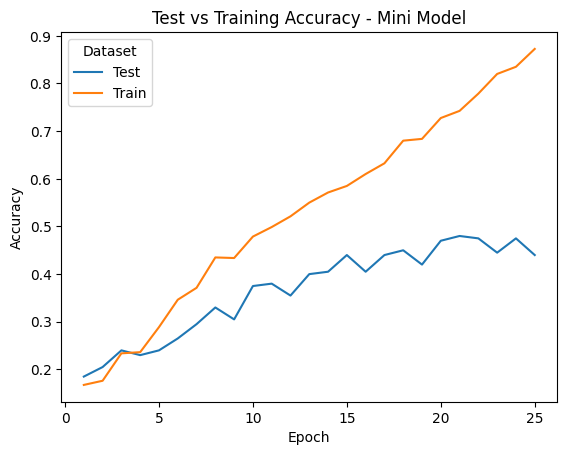

In [46]:
# plot to show the test and training accuracy over time
longform_results = pd.melt(training_results, id_vars=['epoch'], value_vars=['test_acc', 'train_acc'], var_name='Dataset', value_name='accuracy')

label_map = {'test_acc': 'Test', 'train_acc': 'Train'}
longform_results['Dataset'] = longform_results['Dataset'].replace(label_map)

# sns.lineplot(data=training_results, x='epoch', y='loss')
sns.lineplot(data=longform_results, x='epoch', y='accuracy', hue='Dataset')

plt.title('Test vs Training Accuracy - Mini Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

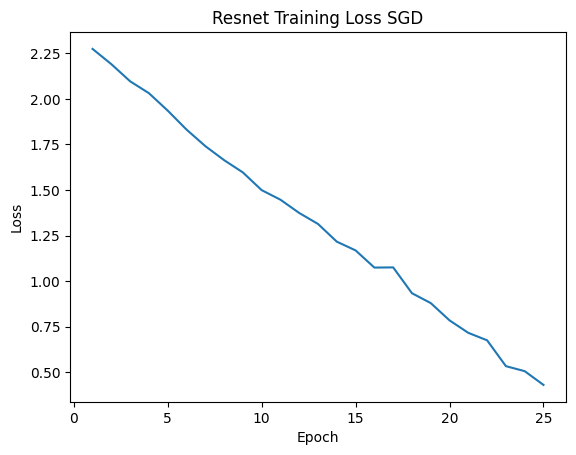

In [61]:
# plot to show the test and training accuracy over time
longform_results = pd.melt(training_results, id_vars=['epoch'], value_vars=['test_acc', 'train_acc'], var_name='Dataset', value_name='accuracy')

sns.lineplot(data=training_results, x='epoch', y='loss')

plt.title('Resnet Training Loss SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [47]:
# load our most accurate state
net.load_state_dict(torch.load('/workspace/mini_state_epoch_21.pth', map_location=device))

<All keys matched successfully>

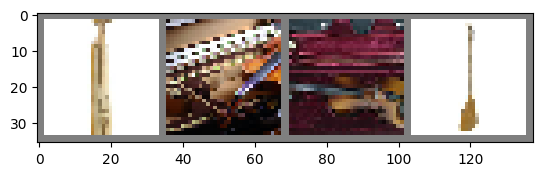

actual: kemence, violin, violin, baglama
predicted: kemence, yayli tambur, harp, baglama


In [49]:
## testing a batch of images

# iterate through the dataset
dataiter = iter(testloader)
batch = next(dataiter)
images = batch['image']
labels = batch['label']

# print some test imagery and labels
imshow(torchvision.utils.make_grid(images.cpu()))
actual = [label_values[labels[i].item()] for i in range(4)]
print('actual: '+', '.join(actual))

# test the model output on these images
outputs = net(images)
predicted = [label_values[i.item()] for i in torch.max(outputs, 1)[1]]
print('predicted: '+', '.join(predicted))

In [50]:
# calculate accuracy
correct = 0
total = 0

for data in testloader:
    images = data['image']
    labels = data['label']

    prediction = net(images)
    predicted = torch.max(prediction, 1)[1]
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'{correct} of {total} images categorized correctly: {100 * correct // total} %')

96 of 200 images categorized correctly: 48 %


In [51]:
# creating a confusion matrix
true_label = []
pred_label = []

# with torch.no_grad():
for data in testloader:
    images = data['image']
    labels = data['label']
    
    output = net(images)
    _, predicted = torch.max(output, 1)
    # predicted = torch.max(prediction, 1)[1]

    true_label.extend(labels.tolist())
    pred_label.extend(predicted.tolist())

In [52]:
# generate confusion matrix
cm = confusion_matrix(true_label, pred_label)

In [53]:
# get labels from dictionary
label_keys = sorted(label_values.keys())  
label_list = [label_values[key] for key in label_keys]

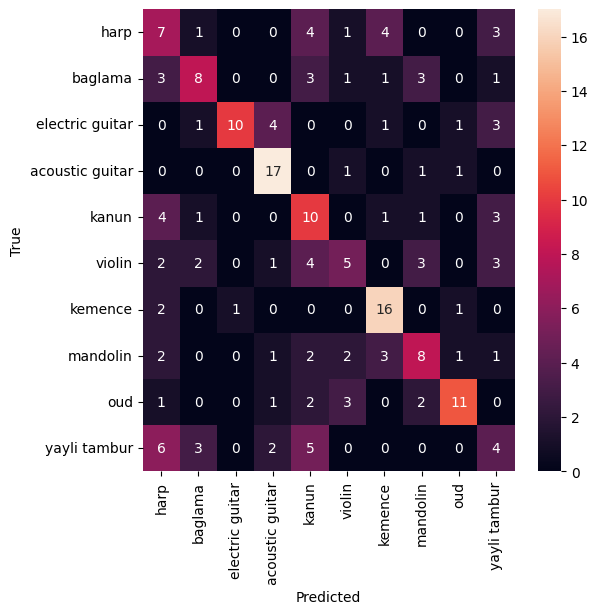

In [54]:
# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

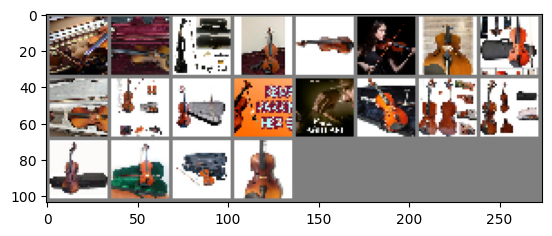

violin | violin | violin | violin | violin | violin | violin | violin
violin | violin | violin | violin | violin | violin | violin | violin
violin | violin | violin | violin | 


Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

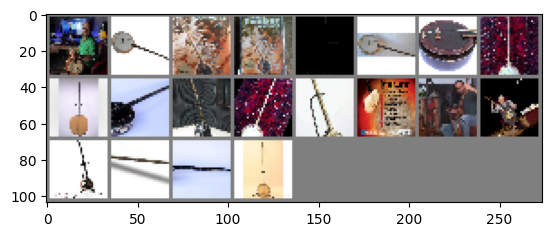

yayli tambur | yayli tambur | yayli tambur | yayli tambur | yayli tambur | yayli tambur | yayli tambur | yayli tambur
yayli tambur | yayli tambur | yayli tambur | yayli tambur | yayli tambur | yayli tambur | yayli tambur | yayli tambur
yayli tambur | yayli tambur | yayli tambur | yayli tambur | 


In [55]:
# compare images from highest and lowest performing instruments (violin/yayli tambur)
check_instrument(5, dataset['test'])
check_instrument(9, dataset['test'])

In [56]:
# examine images that were predicted correctly and incorrectly
def add_predictions(example, i):
    example['predicted_label'] = pred_label[i]
    return example

test_results = dataset['test'].map(add_predictions, with_indices=True)

test_pass = test_results.filter(lambda x: x['label'] == x['predicted_label'])
test_fail = test_results.filter(lambda x: x['label'] != x['predicted_label'])

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

In [59]:
def check_results(ds, limit):

    images = ds['image'][0:limit]
    labels = ds['label'][0:limit]
    predict = ds['predicted_label'][0:limit]

    label_list = ''
    for i, lbl in enumerate(labels):
        true = label_values[labels[i].item()]
        pred = label_values[predict[i].item()]
        print(f'actual: {true} | predicted: {pred}')
        plt.figure(figsize=(1, 1))
        imshow(images[i].cpu())

actual: violin | predicted: yayli tambur


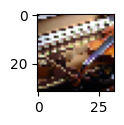

actual: violin | predicted: harp


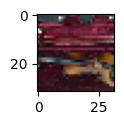

actual: yayli tambur | predicted: harp


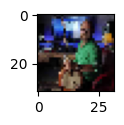

actual: baglama | predicted: mandolin


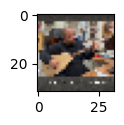

actual: violin | predicted: yayli tambur


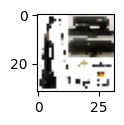

actual: yayli tambur | predicted: acoustic guitar


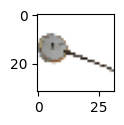

actual: violin | predicted: yayli tambur


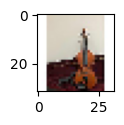

actual: yayli tambur | predicted: kanun


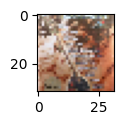

actual: yayli tambur | predicted: kanun


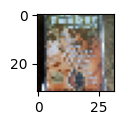

actual: yayli tambur | predicted: harp


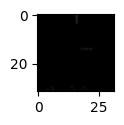

actual: kemence | predicted: electric guitar


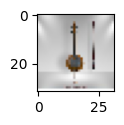

actual: harp | predicted: kanun


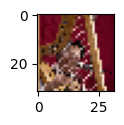

actual: violin | predicted: acoustic guitar


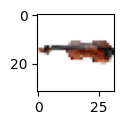

actual: violin | predicted: kanun


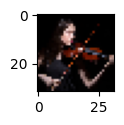

actual: baglama | predicted: kanun


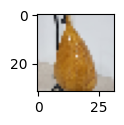

actual: mandolin | predicted: harp


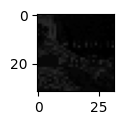

actual: oud | predicted: kanun


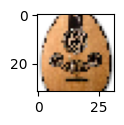

actual: oud | predicted: kanun


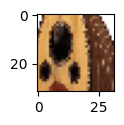

actual: violin | predicted: baglama


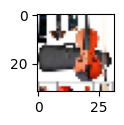

actual: oud | predicted: violin


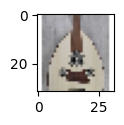

In [60]:
check_results(test_fail, 20)